In [16]:
# sqlContext.clearCache()

In [2]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
# import seaborn as sns

# from nba_utils import draw_3pt_piechart,plot_shot_chart

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib import colorbar as cbar
from matplotlib import cbook as cbook
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import array, col, count, mean, sum, udf, when
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.functions import sum, col, udf
from pyspark.sql.functions import year, month, dayofmonth, hour, minute
from pyspark.sql.types import *

import warnings
warnings.filterwarnings("ignore")

# sns.set_style("white")
# sns.set_color_codes()

In [3]:
customSchema = StructType([ 
    StructField("IncidntNum", StringType(), True), 
    StructField("Category", StringType(), True), 
    StructField("Description", StringType(), True), 
    StructField("DayOfWeek", StringType(), True), 
    StructField("Date_str", StringType(), True), 
    StructField("Time_str", StringType(), True), 
    StructField("District", StringType(), True), 
    StructField("Resolution", StringType(), True), 
    StructField("Address", StringType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("PdId", StringType(), True), ])

In [4]:
crimeDFsource = spark.read.csv('s3a://davidsx/dataSFcrime/', header=True, schema = customSchema)

In [6]:
from pyspark.sql.functions import to_timestamp, concat_ws

crimeDF = crimeDFsource.withColumn("DateTime_str", concat_ws(' ',crimeDFsource.Date_str,crimeDFsource.Time_str))\
.withColumn('Datetime',to_timestamp('DateTime_str', 'MM/dd/yyyy HH:mm').cast(TimestampType()))\

crimeDF = crimeDF.withColumn("Year", year("Datetime")).withColumn("Month", month("Datetime"))\
.withColumn("Hour", hour("Datetime")).withColumn("Minute", minute("Datetime"))

crimeDF = crimeDF.drop('Date_str','Time_str','DateTime_str','Resolution','Location','PdId')
crimeDF.printSchema()

root
 |-- IncidntNum: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Datetime: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)



In [7]:
crimeDF.cache()
sqlContext.registerDataFrameAsTable(crimeDF, 'df')

In [7]:
categories = [u'ARSON', u'ASSAULT', u'BAD CHECKS', u'BRIBERY', u'BURGLARY', u'DISORDERLY CONDUCT',\
              u'DRIVING UNDER THE INFLUENCE', u'DRUG/NARCOTIC', u'DRUNKENNESS', u'EMBEZZLEMENT', \
              u'EXTORTION', u'FAMILY OFFENSES', u'FORGERY/COUNTERFEITING', u'FRAUD', u'GAMBLING', \
              u'KIDNAPPING', u'LARCENY/THEFT', u'LIQUOR LAWS', u'LOITERING', u'MISSING PERSON', \
              u'NON-CRIMINAL', u'OTHER OFFENSES', u'PORNOGRAPHY/OBSCENE MAT', u'PROSTITUTION', \
              u'RECOVERED VEHICLE', u'ROBBERY', u'RUNAWAY', u'SECONDARY CODES', \
              u'SEX OFFENSES, FORCIBLE', u'SEX OFFENSES, NON FORCIBLE', u'STOLEN PROPERTY', \
              u'SUICIDE', u'SUSPICIOUS OCC', u'TREA', u'TRESPASS', u'VANDALISM', u'VEHICLE THEFT',\
              u'WARRANTS', u'WEAPON LAWS']

In [8]:
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

from descartes import PolygonPatch

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep

from itertools import chain

import fiona

shp = fiona.open('sffind_neighborhoods.shp')

# Extract map boundaries
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
# width, height of map
w, h = coords[2] - coords[0], coords[3] - coords[1]

Read SF neighborhood data into Basemap


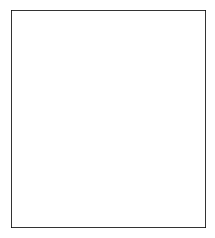

In [9]:
m = Basemap(
    projection='tmerc',
    lon_0=-122.,
    lat_0=37.7,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    'sffind_neighborhoods',
    'SF',
    color='none',
    zorder=2)

print "Read SF neighborhood data into Basemap"

In [10]:
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.SF],
    'ward_name': [ward['name'] for ward in m.SF_info]})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 1000000
# Draw neighborhoods with polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#000000',
    ec='#ffffff', lw=.5, alpha=1,
    zorder=4))
# df_map.count()

In [11]:
def makePoints(dat):
    # Create Point objects in map coordinates from dataframe lon and lat values
    longitude = dat.select('Longitude').rdd.map(lambda x: x[0]).collect()
    latitude = dat.select('Latitude').rdd.map(lambda x: x[0]).collect()
    map_points = pd.Series([Point(m(mapped_x,mapped_y)) for mapped_x, mapped_y in zip(longitude,latitude)])
    plt_points = MultiPoint(list(map_points.values))
    hoods_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
    pts = filter(hoods_polygon.contains,plt_points)
    return pts

In [52]:
crime_from_2015 = crimeDF.where(col('Year')>2014)
# sf_night_crimes.show()

crime_2015 = crime_from_2015.where(col('Year')==2015)
crime_2016 = crime_from_2015.where(col('Year')==2016)
crime_2017 = crime_from_2015.where(col('Year')==2017)
# crime_2018 = crime_from_2015.where(col('Year')==2018)

# crime_pts = makePoints(crime_from_2015)
crime_2015_pts = makePoints(crime_2015)
crime_2016_pts = makePoints(crime_2016)
crime_2017_pts = makePoints(crime_2017)
# crime_2018_pts = makePoints(crime_2018)

In [60]:
crimes_pts_list = [crime_2015_pts, crime_2016_pts, crime_2017_pts]
pts_color = ['yellow', 'cyan', 'orange'] #green,red,orange,yellow,magenta,cyan
pts_label = ['2015', '2016', '2017']
pts_lw = [.25,.5,.75]

def bmScatter(pts_index): 
    m.scatter(
    [geom.x for geom in crimes_pts_list[pts_index]],
    [geom.y for geom in crimes_pts_list[pts_index]],
    10, marker='o', lw=pts_lw[pts_index],
    facecolor=pts_color[pts_index], edgecolor=pts_color[pts_index],
    alpha=0.75, antialiased=True,
    label=pts_label[pts_index], zorder=3)

<Figure size 432x288 with 0 Axes>

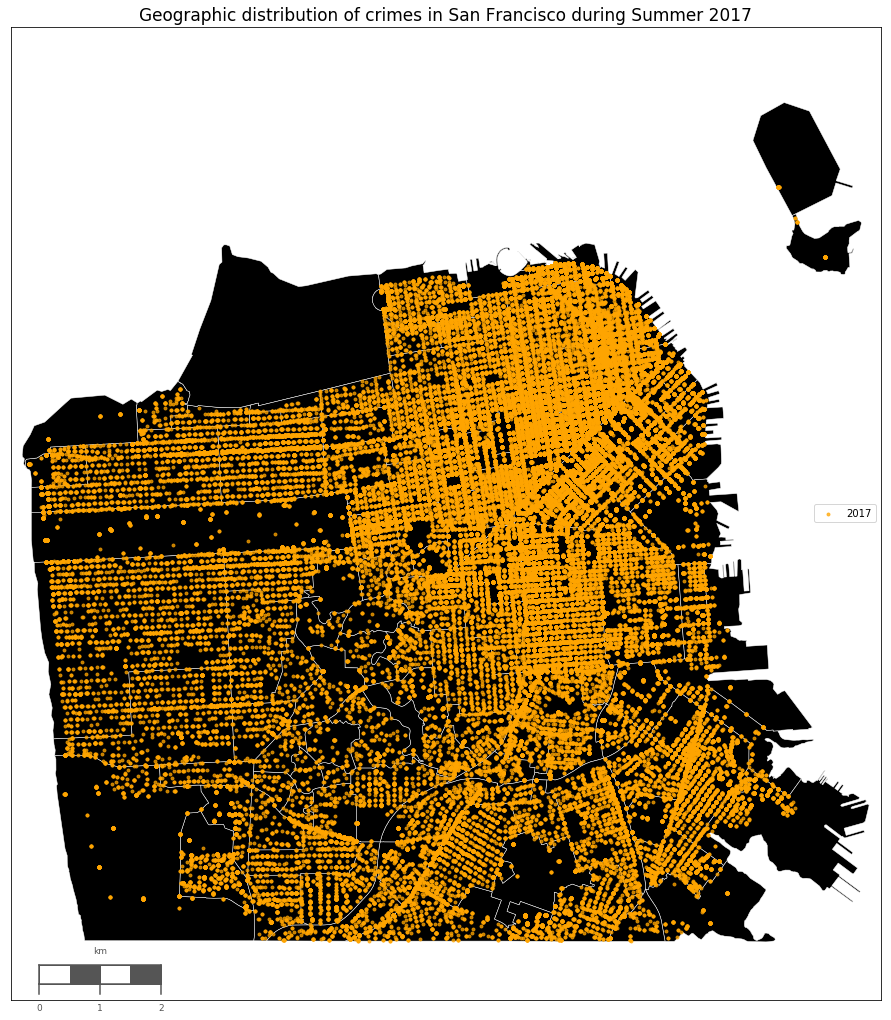

In [61]:
plt.clf()
fig = plt.figure()
fig.add_axes(frameon=False, axisbg='w')
ax = fig.add_subplot(111)

bmScatter(2)
    
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)

plt.tight_layout()
plt.legend(loc="center right")
plt.title("Geographic distribution of crimes in San Francisco during Summer {}".format(pts_label[2]), size=17)
fig.set_size_inches(15,15)
plt.show()

In [13]:
main_crimes = \
[u'WARRANTS',
 u'VANDALISM',
 u'DRUG/NARCOTIC',
 u'VEHICLE THEFT',
 u'ASSAULT',
 u'LARCENY/THEFT']
main_crimes = main_crimes[::-1]
main_crimes

[u'LARCENY/THEFT',
 u'ASSAULT',
 u'VEHICLE THEFT',
 u'DRUG/NARCOTIC',
 u'VANDALISM',
 u'WARRANTS']

In [14]:
main_crime_2017 = crimeDF.where(col('Year').isin(2017)).where(col('Category').isin(main_crimes))

main_crime_2017_list = [1] * len(main_crimes)
main_crime_2017_pts_list = [1] * len(main_crimes)
for i in range(len(main_crimes)):
    main_crime_2017_list[i] = main_crime_2017.where(col('Category')==main_crimes[i])
    main_crime_2017_pts_list[i] = makePoints(main_crime_2017_list[i])

In [15]:
main_crime_2017_pts = makePoints(main_crime_2017)

In [33]:
pts_color = ['cyan', 'magenta', 'yellow', 'red', 'green', 'orange'] #DarkGoldenRod Chocolate Gold Brown 
pts_label = main_crimes
pts_lw = [.25,.3,.35,.4,.45,.5]
crimes_pts_list = main_crime_2017_pts_list

def bmScatter(pts_index): 
    m.scatter(
    [geom.x for geom in crimes_pts_list[pts_index]],
    [geom.y for geom in crimes_pts_list[pts_index]],
    10, marker='o', lw=pts_lw[pts_index],
    facecolor=pts_color[pts_index], edgecolor=pts_color[pts_index],
    alpha=0.75, antialiased=True,
    label=pts_label[pts_index], zorder=3)

<Figure size 432x288 with 0 Axes>

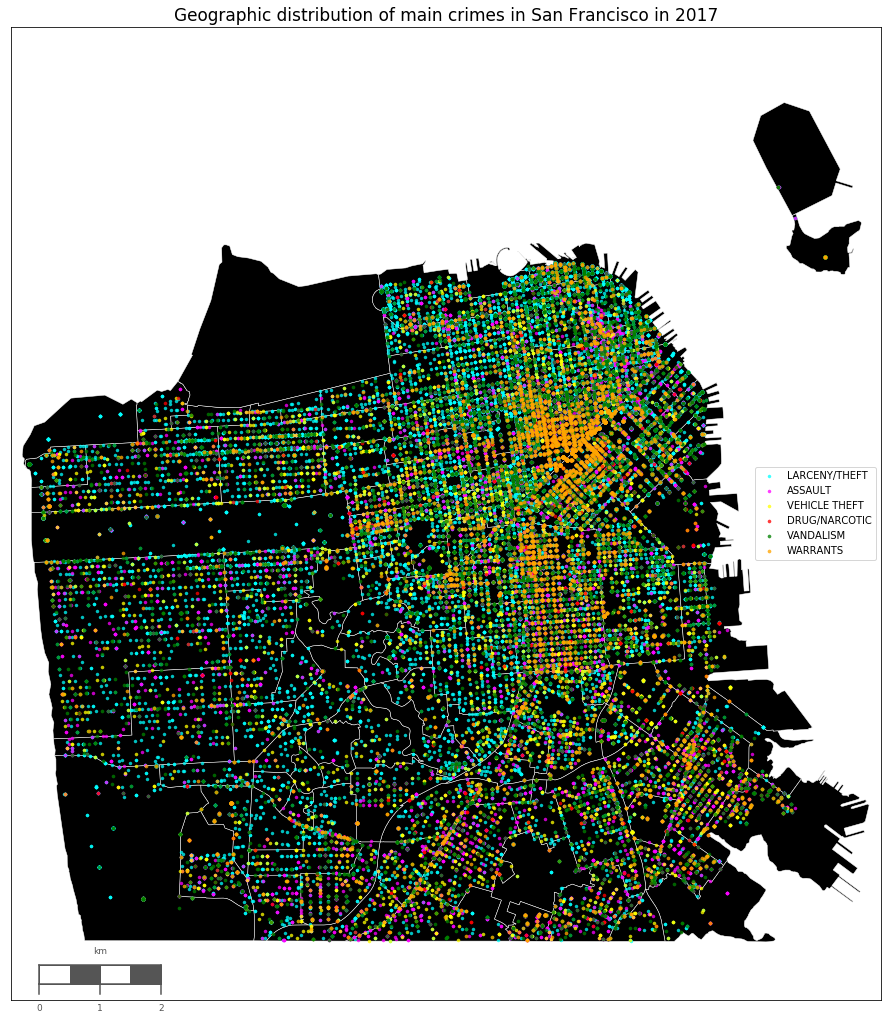

In [34]:
plt.clf()
fig = plt.figure()
fig.add_axes(frameon=False, axisbg='w')
ax = fig.add_subplot(111)

for i in range(len(crimes_pts_list)):
    bmScatter(i)
    
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)

plt.tight_layout()
plt.legend(loc="center right")
plt.title("Geographic distribution of main crimes in San Francisco in 2017", size=17)
fig.set_size_inches(15,15)
plt.show()

In [52]:
df_map['count'] = df_map['poly'].map(lambda x: int(len(filter(prep(x).contains, main_crime_2017_pts))))
df_map['density_m'] = df_map['count'] / df_map['area_m']
df_map['density_km'] = df_map['count'] / df_map['area_km']
# it's easier to work with NaN values when classifying
df_map.replace(to_replace={'density_m': {0: np.nan}, 'density_km': {0: np.nan}}, inplace=True)

df_map.sample(n=5)

,poly,ward_name,area_m,area_km,patches,count,density_m,density_km
111,"POLYGON ((6363.126487251444 7525.407913560858,...",Buena Vista,6.796955e+05,0.679696,"Poly((6363.13, 7525.41) ...)",377,0.000555,554.660101
44,"POLYGON ((4293.14056297073 4866.960904971847, ...",Forest Hill,5.133179e+05,0.513318,"Poly((4293.14, 4866.96) ...)",65,0.000127,126.627196
50,"POLYGON ((6402.054027295671 6210.814662725454,...",Upper Market,5.414637e+05,0.541464,"Poly((6402.05, 6210.81) ...)",227,0.000419,419.234048
10,"POLYGON ((5100.131967371963 9557.828339162397,...",Laurel Heights / Jordan Park,5.832300e+05,0.583230,"Poly((5100.13, 9557.83) ...)",188,0.000322,322.342813
93,"POLYGON ((7527.326043248053 3224.861639991474,...",Mission Terrace,1.274966e+06,1.274966,"Poly((7527.33, 3224.86) ...)",428,0.000336,335.695205


In [123]:
import jenkspy

# Density boundaries
break_density = jenkspy.jenks_breaks(df_map[df_map['density_km'].notnull()].density_km.values,nb_class=5)

# Count
break_count = [1] * 5
for i in range(len(break_density)):
    if i > 0:
        ranges = df_map['density_km'].between(break_density[i-1],break_density[i])
        break_count[i-1] = df_map[ranges]['density_km'].count()

# Index for each categories
break_index = [-1] * (len(df_map)-1)
for i in range(len(df_map)-1):
    for j in range(len(break_density)):
        if j > 0:
            density = df_map['density_km'].array[i]
            check = (density > break_density[j-1]) & (density < break_density[j])
            if check: 
                break_index[i] = j-1
            
        
break_density = break_density[1:len(break_density)]
# break.bins = break_density
# break.counts = break_count
# break.yb = 

In [124]:
len(break_index)

116

In [125]:
# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenks_bins': break_index}, index=df_map[df_map['density_km'].notnull()].index)
df_map.drop("jenks_bins", inplace=True, axis=1, errors="ignore")
df_map = df_map.join(jb)
df_map.jenks_bins.fillna(-1, inplace=True)

# assign labels to the colorbar based on the natural breaks bins
jenks_labels = ["<= %0.1f crimes / km$^2$" % b for b in break_density]
jenks_labels.insert(0, 'No crimes')

<Figure size 432x288 with 0 Axes>

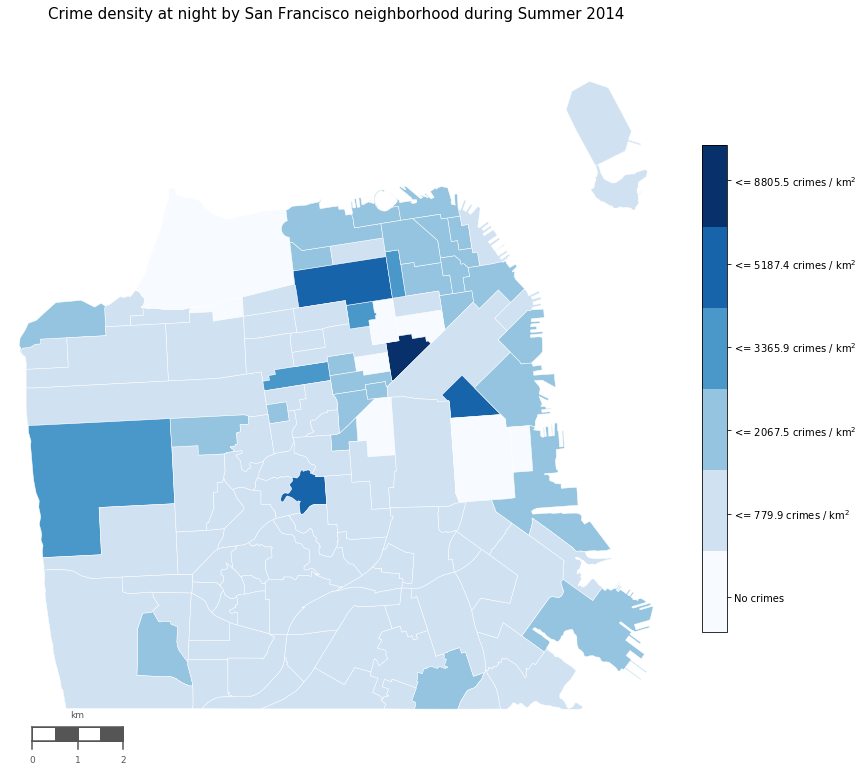

In [127]:
from matplotlib.colors import Normalize, LinearSegmentedColormap 

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')
pc = PatchCollection(df_map['patches'], match_original=True)
# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['jenks_bins'].values)))
ax.add_collection(pc)

# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
cb.ax.tick_params(labelsize=10)

# # Show highest densities, in descending order
# highest = '\n'.join(
#     value[1] for _, value in df_map[(df_map['jenks_bins'] == 4)][:10].sort().iterrows())
# highest = 'Most criminal neighborhoods:\n\n' + highest
# # Subtraction is necessary for precise y coordinate alignment
# details = cb.ax.text(
#     -1., 0 + 0.3,
#     highest,
#     ha='right', va='bottom',
#     size=10,
#     color='#555555')

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.tight_layout()
plt.title("Crime density at night by San Francisco neighborhood during Summer 2014", size=15)
fig.set_size_inches(15, 15)
plt.show()